# Notebook to process the injected waveforms and get detection statistics

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
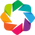

In [1]:
import sys
sys.path.append('../tools')
from plot_tools import *
from map_tools import *
from params import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
mapper = joblib.load('../tools/mapper.sav')
kde = joblib.load('../tools/kde_0_3.sav')
curves = joblib.load('../tools/contours_kde.sav')

Set the injection type and injection set (made several rounds of injections with different parameters, the ones relevant now are all_sky_based and no_constraints)

In [85]:
# inj_type = 'sg'
# inj_type = 'rd'
# inj_type = 'ga'
# inj_type = 'cg'
# inj_type = 'cg_inc'
inj_type = 'cg_double'
# inj_type = 'wn'

inj_set = ''
# inj_set = 'all_sky_based'
# inj_set = 'backup'
# inj_set = 'no_constraints'

data_path = join(features_path, 'fromraw_' + condition_method + '/' + model + '/H1/injected/' + inj_set + '/' + inj_type)
files = [f for f in sorted(listdir(data_path)) if isfile(join(data_path, f)) and f.split('.')[-1] == 'hdf5']
print(len(files))

20


In [86]:
def parse_file_name(file):
    """Function to parse injection file name
    """
    f0 = np.nan
    Q = np.nan
    tau = np.nan
    str_list = file.split('.')[0].split('-')
    inj_type = str_list[1]
    A = float('-'.join(str_list[3:5]))
    if inj_type == 'sg' or inj_type == 'cg' or inj_type == 'cg_inc' or inj_type == 'cg_double':
        f0 = int(str_list[6])
        Q = int(str_list[-1])
    
    elif inj_type == 'rd':
        f0 = int(str_list[6])
        tau = float('-'.join(str_list[-2:]))
    
    elif inj_type == 'ga':
        tau = float('-'.join(str_list[-2:]))
    
    elif inj_type == 'wn':
        f0 = int(str_list[6])
        tau = float('-'.join(str_list[-2:]))
    
    return inj_type, A, f0, Q, tau

In [87]:
x_examples, features_examples, y_examples, times_examples = load_train_examples(condition_method, model, features_path)
labels = np.unique(y_examples)

umap_examples = mapper.transform(features_examples)
tomap = {'ex': {'x': x_examples, 'y': y_examples, 'umap': umap_examples, 'times': times_examples}}

Load map space representations and deviation scores of the injections, and compute their kde_scores

In [88]:
times_tot = []
umap_tot = {'H': [], 'L': []}
y_hat_tot = {'H': [], 'L': []}
kde_scores = {'H': [], 'L': []}
devs = {'H': [], 'L': []}

inj_type_tot = []
A_tot = []
f0_tot = []
Q_tot = []
tau_tot = []
num_points = 0

for num in range(len(files)):
    file = files[num]
    
    for detector in ['H', 'L']:
        data_path = join(features_path, 'fromraw_' + condition_method + '/' + model + '/' + detector + '1/injected/' + inj_set + '/' + inj_type)
        
        with h5py.File(join(data_path, file), 'r') as f:
            umap = np.asarray(f['umap'])
            times = np.asarray(f['times'])
            y_hat = np.asarray(f['y_hat'])
            total_dev = np.asarray(f['total_dev'])
        
        pred_idx = np.argmax(y_hat, axis=1)
        umap_tot[detector].extend(umap)
        y_hat_tot[detector].extend(labels[pred_idx])
        kde_scores[detector].extend(kde.score_samples(umap))
        devs[detector].extend(total_dev)
        if detector == 'H':
            times_tot.extend(times)
        
    num_points += len(times)
    inj_type, A, f0, Q, tau = parse_file_name(file)
    inj_type_tot.extend([inj_type] * len(times))
    A_tot.extend([A] * len(times))
    f0_tot.extend([f0] * len(times))
    Q_tot.extend([Q] * len(times))
    tau_tot.extend([tau] * len(times))

for key in umap_tot.keys():
    umap_tot[key] = np.asarray(umap_tot[key])
    
print(num_points) #, len(times_tot), len(inj_type_tot), len(kde_scores['H']), len(devs['L']))
print(umap_tot['H'].shape, len(y_hat_tot['H']))

df = pd.DataFrame({'time': times_tot, 'inj_type': inj_type_tot, 'A': A_tot, 'f0': f0_tot, 
                   'Q': Q_tot, 'tau': tau_tot, 'H_kde': kde_scores['H'], 
                   'L_kde': kde_scores['L'], 'H_dev': devs['H'], 'L_dev': devs['L'], 
                   'H_pred': y_hat_tot['H'], 'L_pred': y_hat_tot['L']})
display(df.head())

300
(300, 2) 300


,time,inj_type,A,f0,Q,tau,H_kde,L_kde,H_dev,L_dev,H_pred,L_pred
0,1.127032e+09,cg_double,5.000000e-22,30,3,NaN,-5.995096,-4.783790,62.792210,31.181051,Blip,Blip
1,1.136360e+09,cg_double,5.000000e-22,30,3,NaN,-6.338430,-6.262806,185.791394,165.482716,Blip,Blip
2,1.126092e+09,cg_double,5.000000e-22,30,3,NaN,-4.795143,-4.783425,46.723625,75.115601,Blip,Blip
3,1.126581e+09,cg_double,5.000000e-22,30,3,NaN,-4.600386,-4.966487,36.269290,338.214757,Blip,Chirp
4,1.126651e+09,cg_double,5.000000e-22,30,3,NaN,-4.952969,-4.971651,381.521135,126.557656,Blip,Blip


Print the number of injections classified as 'None_of_the_Above'. Not actually used, but the information is nice to have

In [89]:
print(sum(df['H_pred'] == 'None_of_the_Above'))
print(sum(df['L_pred'] == 'None_of_the_Above'))

1
4


Get all injections that are flagged by either method

In [90]:
dev_th = gram_th

df_ood = df.loc[(df['H_kde'] < kde_th) | (df['L_kde'] < kde_th) | (df['H_dev'] > dev_th) | (df['L_dev'] > dev_th)]
# df_ood = df.loc[((df['H_kde'] < kde_th) | (df['L_kde'] < kde_th) | (df['H_dev'] > dev_th) | (df['L_dev'] > dev_th)) & (df['A'] == 6e-20)]
# df_ood = df.loc[((df['H_kde'] < kde_th) | (df['L_kde'] < kde_th)) & ((df['H_dev'] > dev_th) | (df['L_dev'] > dev_th))]
# df_ood = df.loc[(df['H_dev'] > dev_th) | (df['L_dev'] > dev_th)]
display(df_ood.head())
print(len(df_ood))

,time,inj_type,A,f0,Q,tau,H_kde,L_kde,H_dev,L_dev,H_pred,L_pred
106,1.136360e+09,cg_double,1.000000e-21,30,100,NaN,-6.957475,-5.743386,16758.282951,6777.520353,Chirp,Whistle
107,1.126092e+09,cg_double,1.000000e-21,30,100,NaN,-5.493760,-5.676738,14602.539424,4540.637993,Chirp,Whistle
108,1.126581e+09,cg_double,1.000000e-21,30,100,NaN,-5.171258,-6.308946,14955.675807,4222.880914,Chirp,Whistle
109,1.126651e+09,cg_double,1.000000e-21,30,100,NaN,-5.641098,-5.714697,16443.865874,7043.127513,Chirp,Whistle
116,1.126653e+09,cg_double,1.000000e-21,30,100,NaN,-5.998930,-5.437778,16218.884716,15759.749565,Chirp,Chirp


62


Get number of detections for each set of parameters

In [91]:
params_path = Path('../../shared/injection_params')

H_kde_count = []
L_kde_count = []
both_kde_count = []
H_dev_count = []
L_dev_count = []
both_dev_count = []

if inj_type == 'wn':
    params = pd.read_csv(join(params_path, inj_type + '_params_csv.csv'), usecols=['f_low', 'f_high', 'tau', 'A'])
    for f0, tau, A in zip(params['f_low'], params['tau'], params['A']):
        H_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_kde'] < kde_th)))
        L_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['L_kde'] < kde_th)))
        both_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_kde'] < kde_th) & (df['L_kde'] < kde_th)))
        H_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_dev'] > dev_th)))
        L_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['L_dev'] > dev_th)))
        both_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_dev'] > dev_th) & (df['L_dev'] > dev_th)))

elif inj_type == 'rd':
    params = pd.read_csv(join(params_path, inj_type + '_params_csv.csv'), usecols=['f0', 'tau', 'A'])
    for f0, tau, A in zip(params['f0'], params['tau'], params['A']):
        H_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['H_kde'] < kde_th)))
        L_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['L_kde'] < kde_th)))
        both_kde_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['H_kde'] < kde_th) & (df['L_kde'] < kde_th)))
        H_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['H_dev'] > dev_th)))
        L_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['L_dev'] > dev_th)))
        both_dev_count.append(sum((df['f0'] == f0) & (df['tau'] == tau) & (df['A'] == A) & (df['H_dev'] > dev_th) & (df['L_dev'] > dev_th)))

elif inj_type == 'ga':
    params = pd.read_csv(join(params_path, inj_type + '_params_csv.csv'), usecols=['tau', 'A'])
    for tau, A in zip(params['tau'], params['A']):
        H_kde_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['H_kde'] < kde_th)))
        L_kde_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['L_kde'] < kde_th)))
        both_kde_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['H_kde'] < kde_th) & (df['L_kde'] < kde_th)))
        H_dev_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['H_dev'] > dev_th)))
        L_dev_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['L_dev'] > dev_th)))
        both_dev_count.append(sum((df['tau'] == tau) & (df['A'] == A) & (df['H_dev'] > dev_th) & (df['L_dev'] > dev_th)))

else:
    params = pd.read_csv(join(params_path, inj_type + '_params_csv.csv'), usecols=['f0', 'Q', 'A'])
    for f0, Q, A in zip(params['f0'], params['Q'], params['A']):
        H_kde_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_kde'] < kde_th)))
        L_kde_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['L_kde'] < kde_th)))
        both_kde_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_kde'] < kde_th) & (df['L_kde'] < kde_th)))
        H_dev_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_dev'] > dev_th)))
        L_dev_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['L_dev'] > dev_th)))
        both_dev_count.append(sum((df['f0'] == f0) & (df['Q'] == Q) & (round(df['A'] * 1e22) == round(A * 1e22)) & (df['H_dev'] > dev_th) & (df['L_dev'] > dev_th)))

params['H_kde_count'] = H_kde_count
params['L_kde_count'] = L_kde_count
params['both_kde_count'] = both_kde_count
params['H_dev_count'] = H_dev_count
params['L_dev_count'] = L_dev_count
params['both_dev_count'] = both_dev_count

if inj_set == 'no_constraints':
    params['H_dev_%'] = np.asarray(H_dev_count) * 100 / 1000
    params['L_dev_%'] = np.asarray(L_dev_count) * 100 / 1000
    params['both_dev_%'] = np.asarray(both_dev_count) * 100 / 1000

# elif inj_set == 'all_sky_based' or inj_set == '':
#     params.to_csv(join(params_path, inj_type + '_ood_csv.csv'))

idx = pd.Series([False] * len(params))
for col_num in [3, 4, 6, 7]:
    idx |= (params[params.columns[col_num]] != 0)

display(params[idx])

,f0,Q,A,H_kde_count,L_kde_count,both_kde_count,H_dev_count,L_dev_count,both_dev_count
3,30,3,3.000000e-21,0,0,0,0,1,0
7,30,9,3.000000e-21,0,0,0,0,1,0
9,30,100,1.000000e-21,0,0,0,7,4,4
10,30,100,2.000000e-21,0,0,0,12,11,11
11,30,100,3.000000e-21,0,0,0,13,13,12
17,70,100,1.000000e-21,0,0,0,3,2,1
18,70,100,2.000000e-21,0,0,0,11,5,5
19,70,100,3.000000e-21,0,0,0,12,9,9


In [65]:
print(11 + 1 + 7 + 1 + 6 + 1 + 3 + 1 + 1)
print(12 + 11 + 3 + 1 + 13 + 1 + 12 + 7 + 1 + 1)

32
62


Load injection spectrograms

In [66]:
data_path = join(conditioned_path, detector + '1/' + condition_method + '/injected/' + inj_set + '/' + inj_type)
files = [f for f in sorted(listdir(data_path)) if isfile(join(data_path, f)) and f.split('.')[-1] == 'hdf5']

x_tot = {'H': [], 'L': []}

for num in range(len(files)):
    file = files[num]
    
    for detector in ['H', 'L']:
        data_path = join(conditioned_path, detector + '1/' + condition_method + '/injected/' + inj_set + '/' + inj_type)
        with h5py.File(join(data_path, file), 'r') as f:
            x = np.asarray(f['x'])
        x_tot[detector].extend(x)

for key in x_tot.keys():
    x_tot[key] = np.asarray(x_tot[key])
    print(x_tot[key].shape)

(300, 299, 299, 3)
(300, 299, 299, 3)


Set which injections to plot (either all, or just the ones that are flagged)

In [67]:
# plot_idx = 'all'
# plot_idx = 'flagged'
plot_idx = 'flagged_both'

if plot_idx == 'all':
    idx = df.index

elif plot_idx == 'flagged':
    idx = (df['H_kde'] < kde_th) | (df['L_kde'] < kde_th) | (df['H_dev'] > dev_th) | (df['L_dev'] > dev_th)

elif plot_idx == 'flagged_both':
    idx = ((df['H_kde'] < kde_th) & (df['L_kde'] < kde_th)) | ((df['H_dev'] > dev_th) & (df['L_dev'] > dev_th))

for detector in ['H', 'L']:
    tomap[detector] = {'x': x_tot[detector][idx], 'y': np.asarray(y_hat_tot[detector])[idx], 
                       'umap': umap_tot[detector][idx], 'times': np.asarray(times_tot)[idx], 
                       'total_dev': np.asarray(devs[detector])[idx], 
                       'inj_type': np.asarray(inj_type_tot)[idx], 
                       'A': np.asarray(A_tot)[idx], 'f0': np.asarray(f0_tot)[idx], 
                       'Q': np.asarray(Q_tot)[idx], 'tau': np.asarray(tau_tot)[idx]}

for key in tomap['H'].keys():
    print(key, tomap['H'][key].shape)

x (42, 299, 299, 3)
y (42,)
umap (42, 2)
times (42,)
total_dev (42,)
inj_type (42,)
A (42,)
f0 (42,)
Q (42,)
tau (42,)


Plot selected spectrograms

In [68]:
if plot_idx == 'all':
    layout = plot_both_dets(tomap, plot_ex=False, title='all ' + inj_type + ' injections (%d flagged)' % len(df_ood))

elif plot_idx == 'flagged' or plot_idx == 'flagged_both':
    layout = plot_both_dets(tomap, index=df[idx].index, plot_ex=False, title=inj_type + ' injections flagged (%d flagged)' % len(df_ood))

points = layout.Points
H_dmap = layout.DynamicMap.I
L_dmap = layout.DynamicMap.II
width = 400
height = 400
newlay = (points.opts(toolbar='below') * curves + hv.Empty() 
        + H_dmap.opts(frame_width=width, frame_height=height) 
        + L_dmap.opts(frame_width=width, frame_height=height)).opts(merge_tools=False).cols(2)
newlay

:Layout
   .Overlay.I     :Overlay
      .Points.I   :Points   [feature_1,feature_2]   (times,y,marker,size,index)
      .Contours.I :Contours   [x,y]   (z)
   .Empty.I       :Empty
   .DynamicMap.I  :DynamicMap   []
      :RGB   [x,y]   (R,G,B)
   .DynamicMap.II :DynamicMap   []
      :RGB   [x,y]   (R,G,B)

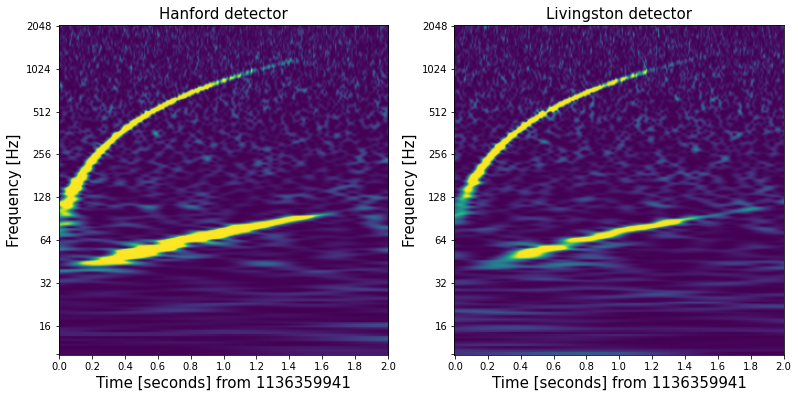

In [69]:
nums = idx[idx == True].index
for num in nums[:1]:
    fig = plt.figure(figsize=(13, 13))
    size = 15
    
    xtick_pos = np.linspace(0, x_tot['H'].shape[1] - 1, 11)
    xtick_label = ["{:.1f}".format(label) for label in np.linspace(0, 2, 11)]

    f_ax = np.flip(np.logspace(np.log10(10), np.log10(2048), x_tot['H'].shape[2]))
    ytick_pos = []
    
    ytick_label = np.flip(np.logspace(4, 11, 8, base=2)).astype('int')
    for tick in ytick_label:
        ytick_pos.append(min(range(len(f_ax)), key=lambda i: abs(f_ax[i] - tick)))
    ytick_pos.append(x_tot['H'].shape[2] - 1)
    
    for i, detector in enumerate(['H', 'L']):
        title = 'Hanford detector' if detector == 'H' else 'Livingston detector'
        ax = fig.add_subplot(1, 2, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(x_tot[detector][num]))
        ax.set_title(title, size=size)
        ax.set_xlabel('Time [seconds] from %d' % round(times_tot[num]), size=size)
        ax.set_ylabel('Frequency [Hz]', size=size)
        ax.set_xticks(xtick_pos)
        ax.set_xticklabels(xtick_label)
        ax.set_yticks(ytick_pos)
        ax.set_yticklabels(ytick_label)
    
    fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/injections/' + inj_type + '/' +
                    '_'.join(['A', str(int(round(A_tot[num] / 1e-22))).zfill(4) + 'e-22', 
                              'f0', str(f0_tot[num]).zfill(4), 'Q', str(Q_tot[num]).zfill(4)]))
#     if not exists(fig_path):
#         makedirs(fig_path)
#     plt.savefig(join(fig_path, 'num_' + str(num) +'.png'))
#     plt.close()

plt.show()

In [113]:
# nums = [88, 122, 45, 144, 179] # cg_inc
# nums = [88, 45] # cg_inc
# nums = [5, 32, 85, 132, 63, 164, 167] # cg_double
# nums = [5, 63, 164] # cg_double

if inj_type == 'cg_inc':
    nums = [184, 257, 221, 297]

elif inj_type == 'cg_double':
    nums = [106, 190, 224, 285] #, 286]

x = {'H': [], 'L': []}
y = {'H': [], 'L': []}
for detector in ['H', 'L']:
    x[detector] = x_tot[detector][nums]
    y[detector] = [item.encode('ascii') for item in np.asarray(y_hat_tot[detector])[nums]]

times = np.asarray(times_tot)[nums]
inj_types = np.asarray(inj_type_tot)[nums]
A = np.asarray(A_tot)[nums]
f0 = np.asarray(f0_tot)[nums]
Q = np.asarray(Q_tot)[nums]

fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/injections')
if not exists(fig_path):
    makedirs(fig_path)

with h5py.File(join(fig_path, inj_type + '.hdf5'), 'w') as f:
    f.create_dataset('nums', data=nums)
    f.create_dataset('times', data=times)
    f.create_dataset('A', data=A)
    f.create_dataset('f0', data=f0)
    f.create_dataset('Q', data=Q)
    f.create_dataset('inj_type', data=[item.encode('ascii') for item in inj_types])
    for detector in ['H', 'L']:
        f.create_dataset('x_' + detector, data=x[detector])
        f.create_dataset('y_' + detector, data=y[detector])

In [114]:
fig_path = Path('paper_figs/mpl_figs/spectrograms/' + condition_method + '/pdfs/injections')
data_dict = {'cg_inc': [], 'cg_double': []}

for inj_type in data_dict.keys():
    x = {'H': [], 'L': []}
    y = {'H': [], 'L': []}
    with h5py.File(join(fig_path, inj_type + '.hdf5'), 'r') as f:
        nums = np.asarray(f['nums'])
        times = np.asarray(f['times'])
        A = np.asarray(f['A'])
        f0 = np.asarray(f['f0'])
        Q = np.asarray(f['Q'])
        inj_types = [item.decode('ascii') for item in np.asarray(f['inj_type'])]
        for detector in ['H', 'L']:
            x[detector] = np.asarray(f['x_' + detector])
            y[detector] = [item.decode('ascii') for item in np.asarray(f['y_' + detector])]
    
    data_dict[inj_type] = {'nums': nums, 'x': x, 'times': times, 'y': y, 'inj_type': inj_types, 
                           'A': A, 'f0': f0, 'Q': Q}

print(data_dict['cg_inc']['x']['H'].shape)
print(data_dict['cg_inc']['y']['H'])
print(data_dict['cg_double']['inj_type'])

(4, 299, 299, 3)
['Chirp', 'Chirp', 'Whistle', 'Whistle']
['cg_double', 'cg_double', 'cg_double', 'cg_double']


In [115]:
det_toplot = ['H', 'L', 'L', 'H']
inj_toplot = ['cg_inc', 'cg_inc', 'cg_double', 'cg_double']
# idx_toplot = [0, 1, 0, 1]
idx_toplot = [1, 3, 1, 3]

count = ['(a) ', '(b) ', '(c) ', '(d) ']

In [116]:
types_dict = {'cg_inc': 'Increasing sweep', 'cg_double': 'Double sweep'}
# amps = ['20.23', '10.10', '5.21', '10.09', '20.19']
# amps = {'cg_inc': ['20', '30', '20', '30'], 'cg_double': ['10', '20', '30', '30']}
amps = {'cg_inc': [20, 30, 20, 30], 'cg_double': [10, 20, 30, 30]}
# amps = {'cg_inc': [20e-22, 30e-22, 20e-22, 30e-22], 'cg_double': [10e-22, 20e-22, 30e-22, 30e-22]}

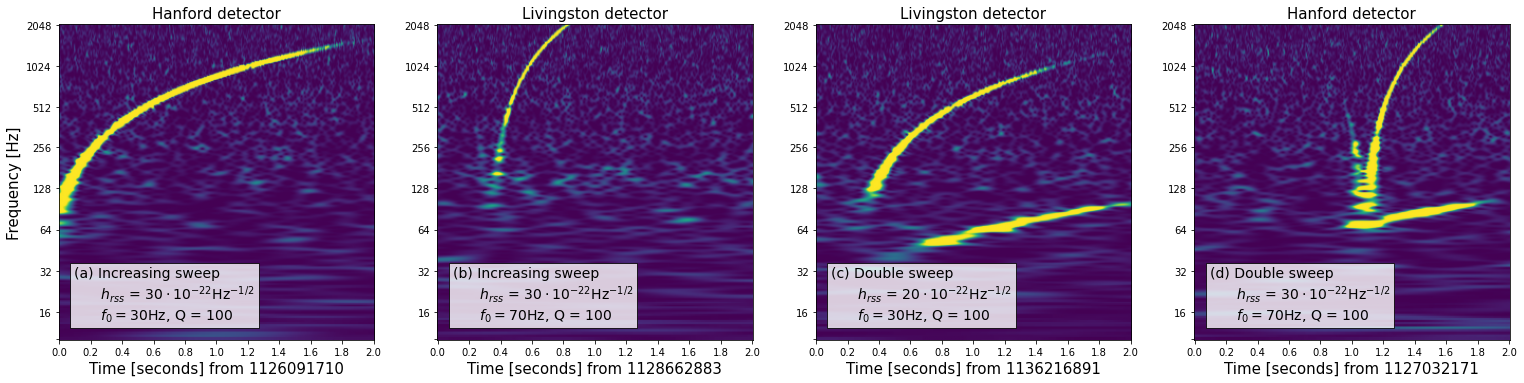

In [120]:
num_rows = 1
num_cols = 4

fig = plt.figure(figsize=(num_cols*6.5, num_rows*6.5))
size = 15

xtick_pos = np.linspace(0, data_dict['cg_inc']['x']['H'].shape[1] - 1, 11)
xtick_label = ["{:.1f}".format(label) for label in np.linspace(0, 2, 11)]

f_ax = np.flip(np.logspace(np.log10(10), np.log10(2048), data_dict['cg_inc']['x']['H'].shape[2]))
ytick_pos = []

ytick_label = np.flip(np.logspace(4, 11, 8, base=2)).astype('int')
for tick in ytick_label:
    ytick_pos.append(min(range(len(f_ax)), key=lambda i: abs(f_ax[i] - tick)))
ytick_pos.append(data_dict['cg_inc']['x']['H'].shape[2] - 1)

for i, (det, inj, idx) in enumerate(zip(det_toplot, inj_toplot, idx_toplot)):
    title = 'Hanford detector' if det == 'H' else 'Livingston detector'
    ax = fig.add_subplot(num_rows, num_cols, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(data_dict[inj]['x'][det][idx]))
    ax.set_title(title, size=size)
    ax.set_xlabel('Time [seconds] from %d' % round(data_dict[inj]['times'][idx]), size=size)
    
    if i % 5 == 0:
        ax.set_ylabel('Frequency [Hz]', size=size)
    
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xtick_label)
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels(ytick_label)
    
    props = dict(facecolor='white', alpha=0.8)
#     count[i] + types_dict[inj] + '$h_{rss}'
    sublabel = '%s%s\n      $h_{rss}$ = $%d \cdot 10^{-22} \mathrm{{Hz}^{-1/2}}$\n      $f_0 = %d\mathrm{Hz}$, Q = %d' % (count[i], types_dict[inj], amps[inj][idx], 
                                                                               data_dict[inj]['f0'][idx], data_dict[inj]['Q'][idx])
    ax.text(0.05, 0.05, sublabel, 
            transform=ax.transAxes, fontsize=14, verticalalignment='bottom', 
            horizontalalignment='left', bbox=props)

# plt.show()
plt.savefig(join(fig_path, 'injections.pdf'), bbox_inches='tight')